# Assignment3 

Welcome to the second assignment! We're excited to see what you'll create using the techniques you've learned in this course.

First of all, please type your name and UID in the following format:

Firstname Lastname, #UID

For example: Sicheng Mo, #401234567

In this assignment we will use Vision Transformer, and pretrained ResNet to to classification on the Miniplaces dataset

In [43]:
#@title Your Info { display-mode: "form" }

Name = 'Rudy Orre' #@param {type:"string"}
UID = '305788790' #@param {type:"string"}

## Goals
The goals of this assignment are to:

1. Build ResNet and Finetune it different strategies
2. Learn how to visualize CNNs.
3. Build a Vision Transformer from scratch .
 

By the end of this assignment, you will have gained experience with:

- Working with PyTorch and the MiniPlaces dataset for image classification.
- Implementing and training different types of neural networks using PyTorch.
- Debugging and troubleshooting issues that may arise during the development process.

Please note that it may take some time to run the entire notebook and prepare the submission version. Make sure to allocate enough time for this task and start early. If you have any questions or run into any issues, please feel free to raise them in the Piazza forum or search the internet for debugging purposes. However, please do not directly copy code from other sources.

This assignment is due on ***Feb 26th***.

**Do not use any Code AI to finish the assignment.**


Good luck and happy coding! Remember, the most important thing is to have fun and learn something new.




## Setup Code


To begin, you will need to download the MiniPlaces dataset using the provided link. 

-----


Recall the introduction about the storage system of CoLab we went through in the assignment 1. For efficient development of our models, we will still use the temporary storage space to hold our data. This means that every time you open up this notebook, we will need to re-download and process the dataset. Don't worry though - this shouldn't take long, usually just a minute or less. Okay, let's get started!

In [44]:
!pip install einops
# Downloading this file takes about a few seconds.
# Download the tar.gz file from google drive using its file ID.
!pip3 install --upgrade gdown --quiet
!gdown 16GYHdSWS3iMYwMPv5FpeDZN2rH7PR0F2 # this is the file ID of miniplaces dataset
# !gdown 1CyIQOJienhNITwGcQ9h-nv8z6GOjV2HX
# back-up commands (try the following it previous file id is overload)
# !gdown 1CyIQOJienhNITwGcQ9h-nv8z6GOjV2HX


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=16GYHdSWS3iMYwMPv5FpeDZN2rH7PR0F2
To: /content/data.tar.gz
100% 460M/460M [00:04<00:00, 107MB/s] 


In [45]:
import os
import tarfile
from tqdm import tqdm
import urllib.request

def setup(file_link_dict={},
          folder_name='Assignment3'):
  # Let's make our assignment directory
  CS188_path = './'
  os.makedirs(os.path.join(CS188_path, 'Assignment3', 'data'), exist_ok=True)
  # Now, let's specify the assignment path we will be working with as the root.
  root_dir = os.path.join(CS188_path, 'Assignment3')
  # Open the tar.gz file
  tar = tarfile.open("data.tar.gz", "r:gz")
  # Extract the file "./Assignment2/data" folder
  total_size = sum(f.size for f in tar.getmembers())
  with tqdm(total=total_size, unit="B", unit_scale=True, desc="Extracting tar.gz file") as pbar:
      for member in tar.getmembers():
          tar.extract(member, os.path.join(root_dir, 'data'))
          pbar.update(member.size)
  # Close the tar.gz file
  tar.close()
  # Next, we download the train/val/test txt files:
  for file_name, file_link in file_link_dict.items():
      print(f'Downloding {file_name}.txt from {file_link}')
      urllib.request.urlretrieve(file_link, f'{root_dir}/data/{file_name}.txt')
  return root_dir

In [46]:
val_url = 'https://raw.githubusercontent.com/CSAILVision/miniplaces/master/data/val.txt'
train_url = 'https://raw.githubusercontent.com/CSAILVision/miniplaces/master/data/train.txt'
root_dir = setup(
    file_link_dict={'train':train_url, 'val':val_url},
    folder_name='Assignment3')

Extracting tar.gz file: 100%|██████████| 566M/566M [00:41<00:00, 13.7MB/s]


Downloding train.txt from https://raw.githubusercontent.com/CSAILVision/miniplaces/master/data/train.txt
Downloding val.txt from https://raw.githubusercontent.com/CSAILVision/miniplaces/master/data/val.txt


### Define the data transform


In [47]:
from torchvision import transforms

# Define data transformation
# You can copy your data transform from Assignment2. 
# Notice we are resize images to 128x128 instead of 64x64.
data_transform = transforms.Compose([
    ################# Your Implementations #####################################
    # TODO: Resize image to 128x128
    transforms.Resize((128, 128)),
    ################# End of your Implementations ##############################
    transforms.ToTensor(),
    ################# Your Implementations #####################################
    # TODO: Normalize image using ImageNet statistics
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ################# End of your Implementations ##############################
])


### Define the dataset and dataloader

In [48]:
# You can copy your dataset from Assignment2. 
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class MiniPlaces(Dataset):
    def __init__(self, root_dir, split, transform=None, label_dict=None):
        """
        Initialize the MiniPlaces dataset with the root directory for the images, 
        the split (train/val/test), an optional data transformation, 
        and an optional label dictionary.
        
        Args:
            root_dir (str): Root directory for the MiniPlaces images.
            split (str): Split to use ('train', 'val', or 'test').
            transform (callable, optional): Optional data transformation to apply to the images.
            label_dict (dict, optional): Optional dictionary mapping integer labels to class names.
        """
        assert split in ['train', 'val', 'test']
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.filenames = []
        self.labels = []

        # Take a second to think why we need this line.
        # Hints: training set / validation set / test set.
        self.label_dict = label_dict if label_dict is not None else {}

        # You should
        #   1. Load the train/val text file based on the `split` argument and
        #     store the image filenames and labels.
        #   2. Extract the class names from the image filenames and store them in 
        #     self.label_dict.
        #   3. Construct a label dict that maps integer labels to class names, if 
        #     the current split is "train" 
        ################# Your Implementations #####################################
         # Test set
        if split == 'test':
            for file in os.listdir(os.path.join(root_dir, 'images', split)):
              self.filenames.append(file[:-4])
            self.filenames.sort()
            return

        # Train/Val sets
        with open(os.path.join(root_dir, split + '.txt')) as open_file:
            for line in open_file:
                filename, label = line.strip().split()
                self.filenames.append(filename)
                self.labels.append(int(label))
                if split == 'train':
                    self.label_dict[int(label)] = filename.split('/')[2]
        ################# End of your Implementations ##############################

    def __len__(self):
        """
        Return the number of images in the dataset.
        
        Returns:
            int: Number of images in the dataset.
        """
        ################# Your Implementations #####################################
        # Return the number of images in the dataset
        return len(self.filenames)
        ################# End of your Implementations ##############################

    def __getitem__(self, idx):
        """
        Return a single image and its corresponding label when given an index.
        
        Args:
            idx (int): Index of the image to retrieve.
            
        Returns:
            tuple: Tuple containing the image and its label.
        """
        image = None
        label = None
        ################# Your Implementations #####################################
        # Load and preprocess image using self.root_dir, 
        # self.filenames[idx], and self.transform (if specified)
        filename = self.filenames[idx]
        label = self.labels[idx]

        if self.split == 'test':
            img_path = os.path.join(self.root_dir, 'images', 'test', filename + '.jpg')
            return self.transform(Image.open(img_path)), filename
        
        img_path = os.path.join(self.root_dir, 'images', filename)
        image = Image.open(img_path)
        image = self.transform(image)
        ################# End of your Implementations ##############################
        return image, label

### Define the train method

In [49]:
def train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs):
    """
    Train the MLP classifier on the training set and evaluate it on the validation set every epoch.
    
    Args:
        model (MLP): MLP classifier to train.
        train_loader (torch.utils.data.DataLoader): Data loader for the training set.
        val_loader (torch.utils.data.DataLoader): Data loader for the validation set.
        optimizer (torch.optim.Optimizer): Optimizer to use for training.
        criterion (callable): Loss function to use for training.
        device (torch.device): Device to use for training.
        num_epochs (int): Number of epochs to train the model.
    """
    # Place model on device
    model = model.to(device)
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        # Use tqdm to display a progress bar during training
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}') as pbar:
            for inputs, labels in train_loader:
                # Move inputs and labels to device
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero out gradients
                optimizer.zero_grad()
                
                # Compute the logits and loss
                logits = model(inputs)
                loss = criterion(logits, labels)
                
                # Backpropagate the loss
                loss.backward()
                
                # Update the weights
                optimizer.step()
                
                # Update the progress bar
                pbar.update(1)
                pbar.set_postfix(loss=loss.item())
        
        # Evaluate the model on the validation set
        avg_loss, accuracy = evaluate(model, val_loader, criterion, device)
        print(f'Validation set: Average loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}')

def evaluate(model, test_loader, criterion, device):
    """
    Evaluate the MLP classifier on the test set.
    
    Args:
        model (MLP): MLP classifier to evaluate.
        test_loader (torch.utils.data.DataLoader): Data loader for the test set.
        criterion (callable): Loss function to use for evaluation.
        device (torch.device): Device to use for evaluation.
        
    Returns:
        float: Average loss on the test set.
        float: Accuracy on the test set.
    """
    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():
        total_loss = 0.0
        num_correct = 0
        num_samples = 0
        
        for inputs, labels in test_loader:
            # Move inputs and labels to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Compute the logits and loss
            logits = model(inputs)
            loss = criterion(logits, labels)
            total_loss += loss.item()
            
            # Compute the accuracy
            _, predictions = torch.max(logits, dim=1)
            num_correct += (predictions == labels).sum().item()
            num_samples += len(inputs)
            
    # Compute the average loss and accuracy
    avg_loss = total_loss / len(test_loader)
    accuracy = num_correct / num_samples
    
    return avg_loss, accuracy

### Define the KNN

In [50]:
def compute_distances_no_loops(x_train, x_test):
  num_train = x_train.shape[0]
  num_test = x_test.shape[0]
  dists = x_train.new_zeros(num_train, num_test)

  A = x_train.reshape(num_train,-1)
  B = x_test.reshape(num_test,-1)
  AB2 = A.mm(B.T)*2
  dists = ((A**2).sum(dim = 1).reshape(-1,1) - AB2 + (B**2).sum(dim = 1).reshape(1,-1))**(1/2)
  return dists

def predict_labels(dists, y_train, k=1):
  num_train, num_test = dists.shape
  y_pred = torch.zeros(num_test, dtype=torch.int64)

  values, indices = torch.topk(dists, k, dim=0, largest=False)
  for i in range(indices.shape[1]):
    _, idx = torch.max(y_train[indices[:,i]].bincount(), dim = 0)
    y_pred[i] = idx
  return indices, y_pred

class KnnClassifier:
  def __init__(self, x_train, y_train):
    self.x_train = x_train
    self.y_train = y_train
    
  def predict(self, x_test, k=1):
    y_test_pred = None

    dists = compute_distances_no_loops(self.x_train, x_test)
    _, y_test_pred =  predict_labels(dists, self.y_train, k)

    return y_test_pred
  
  def check_accuracy(self, x_test, y_test, k=1, quiet=False):
    y_test_pred = self.predict(x_test, k=k)
    num_samples = x_test.shape[0]
    num_correct = (y_test == y_test_pred).sum().item()
    accuracy = 100.0 * num_correct / num_samples
    msg = (f'Got {num_correct} / {num_samples} correct; '
           f'accuracy is {accuracy:.2f}%')
    if not quiet:
      print(msg)
    return accuracy

In [51]:
# Also, seed everything for reproducibility
# code from https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964#file-seed_everything-py
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [52]:
# Define the device to use for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == torch.device('cuda'):
    print(f'Using device: {device}. Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

Using device: cuda. Good to go!


In [53]:
! nvidia-smi

Thu Mar  2 07:01:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    31W /  70W |   2853MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Q1 ResNet (30 pts)

In this question, you will learn how to use pretrained model and apply transfer learning on ResNet18.

### Q1.1 Build the ResNet (5 pts)

In [54]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import cv2
import torchvision.models as models
class Resnet(nn.Module):
    def __init__(self, mode='finetune',pretrained=True):
        super().__init__()
        """
        use the resnet18 model from torchvision models. Remember to set pretrained as true
        
        mode has three options:
        1) features: to extract features only, we do not want the last fully connected layer of 
            resnet18. Use nn.Identity() to replace this layer.
        2) linear: For this model, we want to freeze resnet18 features, then train a linear 
            classifier which takes the features before FC (again we do not want 
            resnet18 FC). And then write our own FC layer: which takes in the features and 
            output scores of size 100 (because we have 100 categories).
            Because we want to freeze resnet18 features, we have to iterate through parameters()
            of our model, and manually set some parameters to requires_grad = False
            Or use other methods to freeze the features
        3) finetune: Same as 2), except that we we do not need to freeze the features and
           can finetune on the pretrained resnet model.
        """
        self.resnet = None
        ########################################Your Code#################################### 
        # Load the resnet18 model
        self.resnet = models.resnet18(pretrained=pretrained)

        if mode == 'features':
            # Freeze all the layers except the final fc layer
            for name, param in self.resnet.named_parameters():
                if name != 'fc':
                  param.requires_grad = False
            
            # Replace the final fc layer with an identity layer
            self.resnet.fc = nn.Identity()
        elif mode == 'linear':
            # Freeze all the layers except the final fc layer
            for name, param in self.resnet.named_parameters():
                if name != 'fc':
                  param.requires_grad = False
            
            # Replace the FC layer (linear classifier)
            self.resnet.fc = nn.Linear(512, 1000)
        elif mode == 'finetune':
            # Replace the FC layer (linear classifier)
            self.resnet.fc = nn.Linear(512, 1000)
        #####################################################################################

    def forward(self, x):
        ########################################Your Code#################################### 
        x = self.resnet(x)
        #####################################################################################
        return x
    
    def to(self,device):
        return self.resnet.to(device=device)

resnet = Resnet('linear')

### Q1.2 Feature comparison (5 pts)
Recall that in Assignment1, we used color histogram features for KNN classification.
In this assignment, we will use features from ResNet18 and compare the results.
#### Color Features
We will first used the color features as in Assignment1. You do not need to implement anything here. Copy your implementation of KNN in model.py, then run the codes below.


In [55]:
seed_everything(0)
data_root = os.path.join(root_dir, 'data')
train_dataset = MiniPlaces(
    root_dir=data_root, split='train', 
    transform=data_transform)

val_dataset = MiniPlaces(
    root_dir=data_root, split='val', 
    transform=data_transform,
    label_dict=train_dataset.label_dict)



sub_sample = list(range(0, len(train_dataset), 50))
print(len(sub_sample))
training_data1 = torch.utils.data.Subset(train_dataset, sub_sample)
training_loader1 = torch.utils.data.DataLoader(training_data1, batch_size=64, shuffle=False, num_workers=2)

sub_sample = list(range(0, len(val_dataset),16))
val_dataset1 = torch.utils.data.Subset(val_dataset, sub_sample)

test_loader = torch.utils.data.DataLoader(val_dataset1, batch_size=128, shuffle=False, num_workers=2)


all_features = []
all_labels = []

for i, data in enumerate(tqdm((training_loader1))):
    inputs, label = data

    all_features.append(inputs)
    all_labels.append(label)

all_features = torch.cat(all_features, dim=0)
all_labels = torch.cat(all_labels, dim=0)

2000


100%|██████████| 32/32 [00:02<00:00, 11.86it/s]


In [56]:
seed_everything(0)


total_acc = 0
true_pos = 0
total = 0
knn = KnnClassifier(all_features, all_labels)
for i, data in enumerate(tqdm((test_loader))):
    inputs, label = data
    acc = knn.check_accuracy(inputs, label, k=10, quiet=True)
    true_pos += acc*inputs.shape[0]
    total += inputs.shape[0]
    
total_acc = true_pos / total
print ("total accuracy is %.2f"%(total_acc/100))

100%|██████████| 5/5 [00:04<00:00,  1.21it/s]

total accuracy is 0.04


I got an accuracy of 4% using my own implementation. How about you?


Implement the Resnet class above. First write the case where "mode=feature". This means that we want to discard the final FC layer of ResNet18.

In [57]:
resnet18 = Resnet(mode='features',pretrained=True)
resnet18.to(device)


all_features = []
all_labels = []

for i, data in enumerate(tqdm((training_loader1))):
    inputs, label = data
    inputs = inputs.cuda()
    cnn_features = resnet18(inputs).detach().cpu()
    
    all_features.append(cnn_features)
    all_labels.append(label)

all_features = torch.cat(all_features, dim=0)
all_labels = torch.cat(all_labels, dim=0)

100%|██████████| 32/32 [00:02<00:00, 13.45it/s]


In [58]:
knn = KnnClassifier(all_features, all_labels)
true_pos = 0
total = 0
for i, data in enumerate(tqdm((test_loader))):
    inputs, label = data
    inputs = inputs.cuda()
    features = resnet18(inputs).detach().cpu()
    acc = knn.check_accuracy(features, label, k=5, quiet=True)
    true_pos += acc*inputs.shape[0]
    total += inputs.shape[0]
    
total_acc = true_pos / total
print ("total accuracy is %.2f"%(total_acc/100))

100%|██████████| 5/5 [00:01<00:00,  4.86it/s]

total accuracy is 0.10


I got an accuracy of 10% using my own implementation. How about you?

What's your opinion on using different features? Pros & Cons?

Your answer

### Q1.3 Pretrained ResNet features + Linear Classifier (5 pts)

Then we implement the “linear” mode in Resnet class in model.py. Remember to freeze the features of ResNet. In this implementation we use linear classifier to do classification on the dataset.

In [59]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
model = Resnet(mode='linear',pretrained=True)

optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=0.005, 
    momentum=0.9)


criterion = nn.CrossEntropyLoss()


# Define the dataset and data transform with flatten functions appended
data_root = os.path.join(root_dir, 'data')
train_dataset = MiniPlaces(
    root_dir=data_root, split='train', 
    transform=data_transform)

val_dataset = MiniPlaces(
    root_dir=data_root, split='val', 
    transform=data_transform,
    label_dict=train_dataset.label_dict)

# Define the batch size and number of workers
batch_size = 64
num_workers = 2

# Define the data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

# Train the model
train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=2)

Epoch 1/2: 100%|██████████| 1563/1563 [02:13<00:00, 11.73it/s, loss=2.71]


Validation set: Average loss = 2.3270, Accuracy = 0.4044


Epoch 2/2: 100%|██████████| 1563/1563 [01:59<00:00, 13.10it/s, loss=2.21]


Validation set: Average loss = 2.2931, Accuracy = 0.4144


I got an accuracy of 40.45% using my own implementation. How about you?

Answing in 2-3 sentence. How does linear evaluation differ from finetuning, and when should we opt for it instead?


Finetuning is where you take a pre-trained model and simply replace the FC layer to change the output size (for a new set of classes) and then just start training on that model with its pre-trained weights. Linear evaluation involves freezing the pre-trained weights and having the model only learn the weights of the output FC layer that we plugged in. While it seems like it would learn less, this would help the model generalize better because it wouldn't overfit teh rest of the weights of the model to the training data, and let the final FC layer do all the learning using the features extracted by the rest of the neural network.

### Q1.4 Finetune pretrained ResNet (15 pts)
Fine-tuning a pre-trained ResNet model on a specific task, such as image classification or object detection, can help improve its performance on that task by adapting the model's learned representations to the particular dataset and task at hand. This is because the pre-trained ResNet has already learned useful feature representations on a large dataset, and fine-tuning allows it to further specialize those representations to the specific task.

In this implementation, instead of freezing resnet features, we want to finetune it. Implement the "finetune" mode in Resnet class in model.py. The implementation is the same as the "linear" mode, except that we do not need to set requires_grad to False to freeze the features. Here, we are going to finetune the ResNet using different strategies.

#### Q1.4.1 Fully finetune with same learning rate (4 pts)
End-to-end finetune with SGD optimizer. Setting lr to 0.01 and momentum to 0.9.

In [60]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
resnet_finetune1 = Resnet(mode='finetune',pretrained=True)

optimizer = None
################# Your Implementations #################################
optimizer = torch.optim.SGD(
    resnet_finetune1.parameters(), 
    lr=0.01, 
    momentum=0.9
)
################# Your Implementations #################################

criterion = nn.CrossEntropyLoss()


# Define the dataset and data transform with flatten functions appended
data_root = os.path.join(root_dir, 'data')
train_dataset = MiniPlaces(
    root_dir=data_root, split='train', 
    transform=data_transform)

val_dataset = MiniPlaces(
    root_dir=data_root, split='val', 
    transform=data_transform,
    label_dict=train_dataset.label_dict)

# Define the batch size and number of workers
batch_size = 64
num_workers = 2

# Define the data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

# Train the model
train(resnet_finetune1, train_loader, val_loader, optimizer, criterion, device, num_epochs=2)

Epoch 1/2: 100%|██████████| 1563/1563 [02:26<00:00, 10.65it/s, loss=2.17]


Validation set: Average loss = 2.0979, Accuracy = 0.4486


Epoch 2/2: 100%|██████████| 1563/1563 [02:26<00:00, 10.65it/s, loss=1.39]


Validation set: Average loss = 2.1145, Accuracy = 0.4625


I got an accuracy of 45.62% using my own implementation. How about you?

#### Q1.4.2 Fully finetune with different learning rates (4 pts)

Lower layers in a network typically learn low-level features such as edges and textures that are useful across a wide range of tasks, and therefore may require smaller updates to prevent overfitting. Meanwhile, higher layers may learn more task-specific features that require larger updates to improve performance.

Here, we finetune the pretrained ResNet with SGD optimizer with momentum = 0.9. We will need to assign different learning rate to different layers.


*   Setting lr to 0.01 for the last fc layer.
*   Setting lr to 0.001 for the rest layers.




In [61]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
resnet_finetune2 = Resnet(mode='finetune',pretrained=True)

optimizer = None
################# Your Implementations #################################
# Hint, read the official document for SGD to check how to set different group of params
# https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
last_fc_layer = []
rest_layers = []
for name, param in resnet_finetune2.named_parameters():
    if name == 'fc':
        last_fc_layer.append(param)
    else:
        rest_layers.append(param)

optimizer = torch.optim.SGD(
    [
        {"params": last_fc_layer, 'lr': 0.01},
        {"params": rest_layers, "lr": 0.001}, 
    ], 
    lr=0.01, 
    momentum=0.9
)
################# Your Implementations #################################


criterion = nn.CrossEntropyLoss()


# Define the dataset and data transform with flatten functions appended
data_root = os.path.join(root_dir, 'data')
train_dataset = MiniPlaces(
    root_dir=data_root, split='train', 
    transform=data_transform)

val_dataset = MiniPlaces(
    root_dir=data_root, split='val', 
    transform=data_transform,
    label_dict=train_dataset.label_dict)

# Define the batch size and number of workers
batch_size = 64
num_workers = 2

# Define the data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

# Train the model
train(resnet_finetune2, train_loader, val_loader, optimizer, criterion, device, num_epochs=2)

Epoch 1/2: 100%|██████████| 1563/1563 [02:24<00:00, 10.84it/s, loss=2.03]


Validation set: Average loss = 1.8933, Accuracy = 0.4883


Epoch 2/2: 100%|██████████| 1563/1563 [02:25<00:00, 10.73it/s, loss=1.26]


Validation set: Average loss = 1.7451, Accuracy = 0.5215


I got an accuracy of 47.23% using my own implementation. How about you?

#### Q1.4.3 Fintune with few forzen layers (3 pts)
Freezing some layers during fine-tuning can help to prevent overfitting and speed up the training process. When we fine-tune a pre-trained neural network, we typically want to retain the learned feature representations in the lower layers of the network, which are often more general and transferable across different tasks. By freezing these lower layers, we prevent their weights from being updated during fine-tuning, which helps to ensure that the model retains its learned feature representations. This can be particularly important if we have a small amount of data available for the specific task we are fine-tuning for.

In this step, you will define a new optimizer to forzen all the parameters in resnet.layer1 and resnet.layer2. 

Here, we finetune the pretrained ResNet with SGD optimizer with momentum = 0.9. We will need to assign different learning rate to different layers.


*   Setting lr to 0.01 for the last fc layer.
*   Setting lr to 0 for the resnet.layer1 and resnet.layer2 layers.
*   Setting lr to 0.001 for the rest layers.


In [62]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
resnet_finetune3 = Resnet(mode='finetune',pretrained=True)


################# Your Implementations #################################
last_fc_layer = []
one_two_layers = []
rest_layers = []
for name, param in resnet_finetune3.named_parameters():
    if 'resnet.fc' in name:
        last_fc_layer.append(param)
    elif 'resnet.layer1' in name:
        one_two_layers.append(param)
    else:
        rest_layers.append(param)

optimizer = torch.optim.SGD(
    [
        {"params": last_fc_layer, 'lr': 0.01},
        {"params": one_two_layers, "lr": 0.0}, 
        {'params': rest_layers, 'lr':  0.001}
    ], 
    lr=0.01, 
    momentum=0.9
)


################# End of your Implementations ##########################


criterion = nn.CrossEntropyLoss()


# Define the dataset and data transform with flatten functions appended
data_root = os.path.join(root_dir, 'data')
train_dataset = MiniPlaces(
    root_dir=data_root, split='train', 
    transform=data_transform)

val_dataset = MiniPlaces(
    root_dir=data_root, split='val', 
    transform=data_transform,
    label_dict=train_dataset.label_dict)

# Define the batch size and number of workers
batch_size = 64
num_workers = 2

# Define the data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

# Train the model
train(resnet_finetune3, train_loader, val_loader, optimizer, criterion, device, num_epochs=2)

Epoch 1/2: 100%|██████████| 1563/1563 [02:25<00:00, 10.76it/s, loss=2.22]


Validation set: Average loss = 1.9241, Accuracy = 0.4881


Epoch 2/2: 100%|██████████| 1563/1563 [02:24<00:00, 10.85it/s, loss=1.21]


Validation set: Average loss = 1.9064, Accuracy = 0.5144


#### Q1.2.4 Comparsion bewteen different method (4 pts)
Q1: Which method perform better in method 1 and method 2. Give a explaination in two to three sentences.

Method 1 was a plain fine-tuning method where all the layers had a learning rate of 0.005. In method 2 we increased the last fc layer's learning rate to 0.01 and decreased the rest of the pre-trained weights to 0.001. What this does is act similarly to freezing the pre-trained weights, but instead we are slowing them down while letting the output layer learning a lot quicker. In this case, model 2 performed better on the validation set.

Q2: Which method perform better in method 2 and method 3. Give a explaination in two to three sentences.

Method 3 was similar to method 2 except we gave a learning rate of 0.0 to the first and second layers (essentially freezing them) and kept the same learning rates for the respective layers from method 2. This actually performed slightly worse (marginally), however I believe method 3 would work better in the long-run since it will overfit less to the training data. The idea of freezing pre-trained weights is because the more upstream a layer is, the more impact it will have that will propogate downstream. If we believe the pre-trained model is already good, then freezing the first couple layers and letting the rest of layers learn would prevent overfitting at the earliest levels of the model.

## Q2 Visulization (10 pts)
The attention maps in Convolutional Neural Networks (CNNs) and Transformers are used to visualize the regions of an input image that the model is paying attention to when making predictions. However, the way these attention maps are computed and the information they convey are different.

### Q2.1 CNN Visualization (10 pts)


Now we will implement Prof. Zhou's famous paper: "Learning Deep Features for Discriminative Localization", in which he proposed class activation mapping (CAM). The main equation is:
$$S_{c}=\sum_{k} w_{k}^{c} \sum_{x, y} f_{k}(x, y)=\sum_{x, y} \sum_{k} w_{k}^{c} f_{k}(x, y)$$
where $f_{k}(x, y)$ represents the activation of unit k in the last convolutional layer, which is layer4 in resnet18.

For more detailed implementation, please refer to the github repo: https://github.com/zhoubolei/CAM

Please implement the CAM function in model.py. Specifically, given convolutional features, weights and a class index, CAM will output the reasons for classifying the image to the class, thus making CNN interpretable.

In [63]:
def CAM(feature_conv, weight_softmax, class_idx):
    """
    Implement CAM here
    generate the class activation maps upsample to 256x256
    refer to: https://github.com/zhoubolei/CAM
    """
    output_cam = []
    ###########################Your Code#######################################
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    #############################################################################
    return output_cam
    

10


100%|██████████| 10/10 [00:00<00:00, 11.15it/s]


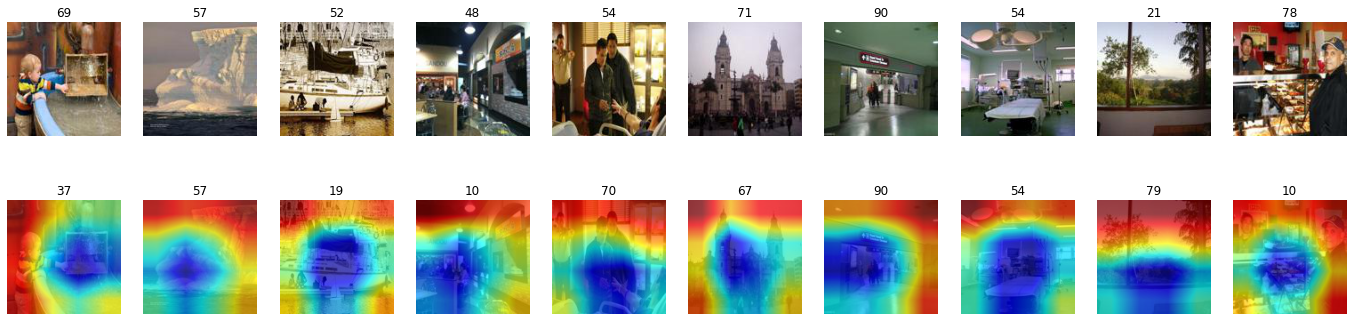

In [64]:
import matplotlib.pyplot as plt


seed_everything(0)
resnet_finetune3.eval()

finalconv_name = 'layer4'
# hook the feature extractor
features_blobs = []

def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

resnet_finetune3.resnet._modules.get(finalconv_name).register_forward_hook(hook_feature)

params = list(resnet_finetune3.parameters())
weight_softmax = np.squeeze(params[-2].data.cpu().numpy())

classes = []
for i in range(100):
  classes.append(str(i))

val_dataset = MiniPlaces(
    root_dir=data_root, split='val', 
    transform=data_transform,
    label_dict=train_dataset.label_dict)
# val_dataset1 = val_dataset[:20]
val_dataset1 = torch.utils.data.Subset(val_dataset, list(range(0,10000,1000)))
print(len(val_dataset1))
val_loader = torch.utils.data.DataLoader(
    val_dataset1, batch_size=1, num_workers=num_workers, shuffle=True)

figure = plt.figure(figsize=(24, 6))
cols, rows = 10, 2
counter = 0 

for i, data in enumerate(tqdm((val_loader))):
    features_blobs = []
    img, label = data
    img = img.cuda()
    
    logit = resnet_finetune3(img)
    
    h_x = F.softmax(logit, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.cpu().numpy()
    idx = idx.cpu().numpy()

    # generate class activation mapping for the top1 prediction
    CAMs = CAM(features_blobs[0], weight_softmax, [idx[0]])

    img = img.squeeze().permute(1,2,0)
    height, width, _ = img.shape
    img = img.cpu() * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = img.cpu().numpy()
    heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
    heatmap = heatmap/255
    result = heatmap * 0.7 + img * 0.3
    
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.title(classes[label])
    plt.imshow(img, cmap="gray")

  
    figure.add_subplot(rows, cols, i+11)
    plt.axis("off")
    plt.title(classes[idx[0]])

    plt.imshow(result, cmap="gray")
    counter +=1 

plt.show()

## Q3: Steps to build a ViT from scratch (60 pts)
Vision Transformer (ViT) is a state-of-the-art neural network architecture for image classification tasks. Unlike traditional convolutional neural networks (CNNs), which have been the standard in computer vision for many years, ViT relies on a self-attention mechanism to extract features from images. This approach has shown to achieve competitive results on various benchmark datasets, while also offering the flexibility to handle tasks that require attention over long-range dependencies in images. ViT has quickly gained popularity in the computer vision community, and has spurred further research into the use of self-attention mechanisms in other areas of deep learning.

You will implement the ViT model on the Miniplaces dataset.

To implement ViT model for image classification, you will need to follow these steps：
1.  Extract feature vectors from the input images using a trainable linear projection layer, which converts the 2D image patches into 1D feature vectors.
2. Positional encoding: Add a learnable positional encoding to each feature vector, which provides spatial information to the model.
3. Transformer encoder: Stack multiple Transformer encoder layers to process the encoded features, which allows the model to learn both local and global interactions between the image patches.
4. Classification head: Add a classification head on top of the final encoded feature vector, which maps the learned representations to the corresponding class labels.
5. Training and evaluation: Train the ViT model using an appropriate optimization algorithm and loss function, and evaluate its performance on the validation and testing sets.

If you are not familiair with ViT model, then you can read our textbook [Transformers for Vision](https://d2l.ai/chapter_attention-mechanisms-and-transformers/vision-transformer.html#fig-vit), or review our [discussion slides](https://drive.google.com/file/d/1RKSnE9MOAGBu9T-_2TaBEm4ASF189Fms/view). 

### Q3.1: Tokenization (10 pts): 
At this step, we need to divide each image into a set of non-overlapping patches, and treat each patch as a token. This is the key step that distinguishes ViT from other computer vision models.

#### Q3.1.1 Tokenize_image Method (5pts)

In [65]:
def tokenize_image(img, patch_size=16, stride=16):
    """
    Tokenize an image into non-overlapping image patches.
    Args:
        img (torch.Tensor): The input image with shape (C, H, W).
        patch_size (int): The size of each patch.
        stride (int): The stride of the sliding window.
    Returns:
        patches (torch.Tensor): The tokenized patches with shape (N, patch_size*patch_size*C).
    """
    
    C, H, W = img.shape
    patches = []
    ################# Your Implementations #################################
    # Hints: write two for loop to loop over this image 
    # Each patch is flattened into a 1-dimensional vector and stacked into a 
    # tensor with shape (N, C * patch_size(H) * patch_size(W)), where N is the number of patches. 
    # We only consider the case image size can be modulo by the patch_size

    # Modulo Validation
    if H % patch_size != 0 or W % patch_size != 0:
        return

    # Compute number of patches (N)
    patch_H, patch_W = int(H / patch_size), int(W / patch_size)
    N = patch_H * patch_W

    # Permute dimensions (such that color is last)
    img = img.permute(1, 2, 0)

    patches = [[] for _ in range(N)]
    for i in range(len(img)):
        for j in range(len(img[i])):
            patch_i = i // patch_size
            patch_j = j // patch_size
            patches[patch_j + patch_i * patch_W] += img[i, j].tolist()

    # Convert to tensor (and add extra dimension)
    patches = torch.stack(list(map(torch.tensor, patches)))
    patches = torch.unsqueeze(patches, dim=0)

    ################# End of your Implementations ##########################
    return patches

random_img = torch.rand(3,64,64)
patched_img = tokenize_image(random_img,32,32)
patched_img.shape

torch.Size([1, 4, 3072])

In [66]:
# test your implementation of tokenize_image
random_img = torch.rand(3,64,64)
patched_img = tokenize_image(random_img,8,8)

for i in [2, 32,16,8,4,2]:
    out = tokenize_image(random_img,i,i)
    
    fast_patch = Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = i, p2 = i)
    
    answer = fast_patch(random_img.unsqueeze(0))
    equal = torch.allclose(out,answer.squeeze(0))
    #print('Difference: ', equal)
    if equal:
      print('Good! For patch_size: %d, the output match' %(i))
    else:
      print('Uh-oh! For patch_size: %d, the output are different' %(i))
      break

Good! For patch_size: 2, the output match
Good! For patch_size: 32, the output match
Good! For patch_size: 16, the output match
Good! For patch_size: 8, the output match
Good! For patch_size: 4, the output match
Good! For patch_size: 2, the output match


#### Q3.1.1 linear projection layer (5 pts)

At this step, you will need to implement the linear projection linear project layer combined with tokenize operation. 

This layer is used to transfer a single image to the image embedding. 

In [67]:
class Tokenization_layer(nn.Module):
  def __init__(self, dim, patch_dim, patch_height, patch_width):
    super().__init__()
    """
        Args:
          dim (int): input and output dimension.
          patch_dim(int): flattened vector dimension for image patch
          patch_height (int): height of one image patch
          patch_weight (int): weight of one image patch
        
        You can use Pytorch's built-in function and the above Rearrange method.
        Input and output shapes of each layer:
        1) Rerrange the image: (batch_size, channels, H,W) -> (batch_size,N,patch_dim)
        2) Norm Layer1 (LayerNorm): (batch_size,N,patch_dim) -> (batch_size,N,patch_dim)
        3) Linear Projection layer: (batch_size,N,patch_dim) -> (batch_size,N,dim)
        4) Norm Layer2 (LayerNorm): (batch_size,N,dim)-> (batch_size,N,dim)
    """

    self.to_patch = Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_height, p2=patch_width)
    self.norm1 = None 
    self.fc1 = None
    self.norm2 = None

    ################# Your Implementations #################################
    # Hints: You can use the Rearrange method above to achieve faster patch operation
    # Append this layer to nn.Sequential 
    # Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width)
    self.patch_dim = patch_dim
    self.norm1 = nn.LayerNorm(patch_dim)
    self.fc1 = nn.Linear(patch_dim, dim)
    self.norm2 = nn.LayerNorm(dim)
    self.tokenization_layer = nn.Sequential(
        self.to_patch,
        self.norm1,
        self.fc1,
        self.norm2,
    )
    ################# End of your Implementations ##########################

  def forward(self, x):
    """
    Args:
      x (torch.Tensor): input tensor in the shape of (batch_size,C,H,W)
    Return: 
      out (torch.Tensor): output patch embedding tensor in the shape of (batch_size,N,dim)

     The input tensor 'x' should pass through the following layers:
     1) self.to_patch: Rerrange image 
     2) self.norm1: LayerNorm
     3) self.fc1: Fully-Connected layer
     4) self.norm2: LayerNorm

    """
    ################# Your Implementations #################################
    x = self.tokenization_layer(x)
    ################# End of your Implementations ##########################
    return x

### Q3.2 Attention (15 pts): 
You will need to follow the steps to implement multi-head attention in this question. 
1. **Obtain Q,K,V vectors**: To obtain the Q, K, and V vectors, the input vectors are processed through three distinct single linear layers. In our implementation, we use a single linear layer with 3xD output channels, and then we divide the output into three chunks. We consider the first chunk as the Q vectors, the second chunk as the K vectors, and the last chunk as the V vectors. 

2. **Calculate similarity**: Compute the similarity scores between query vectors and a set of key vectors using a dot product.

3. **Apply softmax**: Apply a softmax function to normalize the similarity scores across the key vectors. This creates a probability distribution that represents the relative importance of each key vector with respect to the query vector.

4. **Compute weighted sum**: Compute a weighted sum of the** value vectors**, where the weights are the probability distribution obtained in step 2. This produces a context vector that summarizes the most relevant information from the value vectors with respect to the query vector.

5. **Concatenate output**: The outputs of each head are then concatenated and passed through another linear projection to produce the final output.

For more details, you can read our [textbook](https://d2l.ai/chapter_attention-mechanisms-and-transformers/index.html).

In [68]:
class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        """
        Args:
          dim (int): input and output dimension.
          heads (int): number of attention heads.
          dim_head (int): input dimension of each attention head.
          dropout (float): dropout rate for attention and final_linear layer.

        Initialize a attention block.
        You can use Pytorch's built-in function.
        Input and output shapes of each layer:
        1) Define the inner dimension as number of heads* dimension of each head
        2) to_qkv: (batch_size, dim) -> (batch_size,3*inner_dimension)
        3) final_linear: (batch_size, inner_dim) -> (batch_size, dim)
        """
        
        self.heads = heads
        self.dim_head = None
        self.to_qkv = None
        self.dropout = None
        
        self.inner_dim = dim_head *  heads    
        self.to_qkv = nn.Linear(dim, self.inner_dim * 3, bias=False)
        ################# Your Implementations #################################
        self.heads = heads
        self.dim_head = dim_head
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=0)
        self.final_linear = nn.Linear(self.inner_dim, dim)
        ################# End of your Implementations ##########################
        
    def forward(self, x):
        '''
        Forward pass of the attention block.
        Args:
            x (torch.Tensor): input tensor in the shape of (batch_size,N,dim).
        Returns:
            out (torch.Tensor): output tensor in the shape of (batch_size,N,dim).
        
        The input tensor 'x' should pass through the following layers:
        1) to_qkv: (batch_size,N,dim) -> (batch_size,N,3*inner_dimension)
        2) Divide the ouput of to qkv to q,k,v and then divide them in to n heads 
            (batch_size,N,inner_dim) -> (batch_size,N,num_head,head_dim)
        3) Use torch.matmul to get the product of q and k
        4) Divide the above tensor by the square root of head dimension
        5) Apply softmax and then dropout on the above tensor
        6) Mutiply the above tensor with v to get attention
        7) Concatenate the attentions from multi-heads 
            (batch_size,N,num_head,head_dim) -> (batch_size,N,inner_dim)
        8) Pass the output from last step to a fully connected layer 
        9) Apply dropout for the last step output    
        '''
        out = None
        
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)
        ################# Your Implementations #################################
        # Transpose for because of shape: (batch_size, num_heads, query/key, head_dim)
        out = torch.matmul(q, k.transpose(2, 3)) 
        # Divide by sqrt of head dim
        out = out / (self.dim_head ** 0.5)
        # Softmax along the last dimension (key)
        out = F.softmax(out, dim=3)
        out = self.dropout(out)
        out = torch.matmul(out, v)
        # Hint you can use :
        #    out = rearrange(out, 'b h n d -> b n (h d)')
        # to concatenate the output from all attention heads
        # This operation will change the tensor shape from (batch_size,N,num_head,head_dim)
        # to  (batch_size,N,inner_dim)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.final_linear(out)
        out = self.dropout(out)
        ################# End of your Implementations ##########################
        return out

In [69]:
# You can use this cell to check if the output shape of attention'
for dim in [512,768,1096]:
  test_tensor = torch.rand(2,196,dim)
  att_layer = Attention(dim,8,64,0.4)
  output_tensor = att_layer(test_tensor)
  equal =  test_tensor.shape == output_tensor.shape
  if equal:
    print('Good! For input dim: %d, the output shape is correct' %(dim))
  else:
    print('Uh-oh! For input dim: %d, the output shape is wrong' %(dim))
    break

Good! For input dim: 512, the output shape is correct
Good! For input dim: 768, the output shape is correct
Good! For input dim: 1096, the output shape is correct


The norm layer in Vision Transformer (ViT) is a layer that performs layer normalization on the input. It is typically applied after the Multi-Head Attention (MHA) and the MLP layers in the ViT architecture. The norm layer is used to help the model learn better representations by ensuring that the activations are normalized and centered.

In [70]:
### PreNorm function
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        # keey the resiual connection here
        return self.fn(self.norm(x), **kwargs)+x

In [71]:
#You can use 
a = PreNorm(768, Attention(768, heads = 8, dim_head = 64, dropout = 0.2))
# to create a combination of layer norm and any other layer
test_tensor = torch.rand(2,196,768)
# you can use the following line to do the forward pass
output_tensor = a(test_tensor)

###Q3.3 PositionwiseFeedForward(5 pt)
You will need to implement the posiotionwiseFeedForward layer in Vision Transformer. 

The FFN layer is called "position-wise" because it applies a separate feedforward network to each position in the sequence independently. It consists of two linear transformations with a non-linear activation function in between, typically GELU. The first linear transformation maps the input feature vector from its original dimension to a higher-dimensional space, and the second linear transformation maps it back to the original dimension. The output of the FFN layer is the element-wise sum of the input and the transformed feature vector.

In [72]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, dim, mlp_dim, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        """
         Args:
          dim (int): input and output dimension.
          mlp_dim (int): the output dimension of the fist first layer.
          dropout (float): dropout rate for both linear layers.

        Initialize an MLP.
        You can use Pytorch's built-in nn.Linear function.
        Input and output sizes of each layer:
          1) fc1: dim, mlp_dim
          2) fc2: mlp_dim, dim
        """ 

        self.fc1 = None
        self.fc2 = None
        self.dropout = None
        self.activation = nn.GELU()
        ################# Your Implementations #################################
        self.fc1 = nn.Linear(dim, mlp_dim)
        self.fc2 = nn.Linear(mlp_dim, dim)
        self.dropout = nn.Dropout(dropout)
        ################# End of your Implementations ##########################
        
    def forward(self, x):
        '''
        Args:
            x (torch.Tensor): input tensor in the shape of (batch_size,N,dim).
        Returns:
            out (torch.Tensor): output tensor in the shape of (batch_size,N,dim).
        
        The input tensor 'x' should pass through the following layers:
        1) fc1: (batch_size,N,dim) ->  (batch_size,N,mlp_dim)
        2) Apply activation function 
        3) Apply dropout
        3) fc2: (batch_size,N,mlp_dim) -> (batch_size,N,dim)
        4) Apply dropout
        '''
        ################# Your Implementations #################################
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        ################# End of your Implementations ##########################
        return x

In [73]:
# You can use this cell to check if the output shape of PositionwiseFeedForward
for dim in [512,768,1096]:
  test_tensor = torch.rand(2,196,dim)
  ffn = PositionwiseFeedForward(dim,dim*4,0.1)
  output_tensor = ffn(test_tensor)
  equal =  test_tensor.shape == output_tensor.shape
  if equal:
    print('Good! For input dim: %d, the output shape is correct' %(dim))
  else:
    print('Uh-oh! For input dim: %d, the output shape is wrong' %(dim))
    break

Good! For input dim: 512, the output shape is correct
Good! For input dim: 768, the output shape is correct
Good! For input dim: 1096, the output shape is correct


### Q3.4 TransformerBlock (5pt)
Now you can follow the steps and use above class to implement the standard transformer block as demostrated in the following image.

 <img src="https://web.cs.ucla.edu/~smo3/cs188/assignment3/transformer_block.png"  width="20%" height="40%">

1. Apply Layer-norm to the input tensor
2. Apply the Multi-Head Attention (MHA) layer to the output tensor from step1. The MHA layer takes in the input tensor, and returns the attention scores and the attention output tensor.
3. Add the residual connection to the output of the MHA layer.
4. Apply Layer-norm to output of last step
5. Apply the Position-wise Feedforward Network (FFN) layer to the output of the previous step. The FFN layer takes in the output tensor, and returns the transformed output tensor.
6. Add the residual connection to the output of the FFN layer.

In [74]:
class Transformer(nn.Module):
    def __init__(self, dim, heads, dim_head, mlp_dim, dropout = 0.):
        "Implements Transformer block."
        super().__init__()
        '''
        Args:
          dim (int): input and output dimension.
          heads (int): number of attention heads.
          dim_head (int): input dimension of each attention head.
          mlp_dim (int): 
          dropout (float): dropout rate for attention and FFN layers.
        
        '''
        # Use the PreNorm,Attention and PositionwiseFeedForword class to build your 
        # Transformer block
        self.attn = None
        self.ff = None
        
        ################# Your Implementations #################################
        # a = PreNorm(768, Attention(768, heads = 8, dim_head = 64, dropout = 0.2))
        # self.attn = Attention(dim, heads, dim_head, dropout)
        # self.ff = PositionwiseFeedForward(dim, mlp_dim, dropout)
        self.attn = PreNorm(dim, Attention(dim, heads, dim_head, dropout))
        self.ff = PreNorm(dim, PositionwiseFeedForward(dim, mlp_dim, dropout))
        ################# End of your Implementations ##########################
        
    def forward(self, x):
        """
        Args:
            x (torch.Tensor): input tensor in the shape of (batch_size,N,dim).
        Returns:
            out (torch.Tensor): output tensor in the shape of (batch_size,N,dim).
        """
        ################# Your Implementations #################################
        residual = x
        x = self.attn(x)
        x += residual
        residual = x
        x = self.ff(x)
        x += residual
        ################# End of your Implementations ##########################
        return x

In [75]:
# You can use this cell to check if the output shape of Transformer
for dim in [512,768,1096]:
  test_tensor = torch.rand(2,196,dim)
  transformer_block = Transformer(dim,8,64,dim*4,0.1)
  output_tensor = transformer_block(test_tensor)
  equal =  test_tensor.shape == output_tensor.shape
  if equal:
    print('Good! For input dim: %d, the output shape is correct' %(dim))
  else:
    print('Uh-oh! For input dim: %d, the output shape is wrong' %(dim))
    break

Good! For input dim: 512, the output shape is correct
Good! For input dim: 768, the output shape is correct
Good! For input dim: 1096, the output shape is correct


###Q3.5 ViTModel (20 pts)
Now you can use above classes to build your Vision Transfromer. Recall the ViT Architecture. 

 <img src="https://web.cs.ucla.edu/~smo3/cs188/assignment3/vit.png"  width="40%" height="40%">

 Recall the pipline for Vision Transformer model:

1. Load the input images and preprocess them into a set of image patches. The patches should be non-overlapping and should cover the entire input image. Each patch should be flattened into a vector and projected into a lower-dimensional/equal-dimensional space using a linear layer.

2. Add cls token and learnable positional embeddings to the projected patch vectors. The positional embedding should encode the spatial location of each patch in the input image.

3. Stack several Transformer blocks to process the patch vectors. Each Transformer block should consist of a Multi-Head Attention (MHA) layer and a Position-wise Feedforward Network (FFN) layer, with residual connections and layer normalization applied after each layer.

3. Apply a mean pooling operation over the output of the last Transformer block or take the output vector related to the cls token to obtain a fixed-size feature vector.

5. Feed the feature vector into a fully-connected classification head to predict the class label of the input image.

6. Train the model using a supervised learning objective, such as cross-entropy loss, and backpropagation to update the model weights.

In [76]:
# helper method
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class ViT(nn.Module):
    "Implements Vision Transfromer"
    def __init__(self, *, 
                 image_size,
                 patch_size, 
                 num_classes, 
                 dim, 
                 depth, 
                 heads, 
                 mlp_dim, 
                 pool='cls', 
                 channels=3, 
                 dim_head=64, 
                 dropout=0., 
                 emb_dropout=0.,
                ):
        super().__init__()
        """
        Args:
          image_size (int): the height/weight of the input image.
          patch_size (int): image patch size. In the ViT paper, this value is 16.
          num_classes (num_class): Number of image classes for MLP prediction head.
          dim (int): patch and position embedding dimension.
          depth (int): number of stacked transformer blocks.
          heads (int): number of attention heads.
          mlp_dim (int): inner dimension for MLP in transformer blocks.
          pool (str): choice between "cls" and "mean".
                      For cls, you will need to use the cls token for perdiction
                      For mean, you will need to take the mean of last transformer output 
          channels (int): Input image channels. Set to 3 for RGB image.
          dropout (float): dropout rate for transformer blocks.
          emb_dropout (float): dropout rate for patch embedding.
        
        """
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = 0
        patch_dim = 0
        
        ################# Your Implementations #################################
        # TODO: Compute the num_patches and patch_dim
        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        ################# End of your Implementations ##########################
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
        self.pool = pool

        self.to_path_embedding = None

        self.pos_embedding = None
        self.cls_token = None
        self.dropout = None
        self.transformers = nn.ModuleList([])
        self.mlp_head = None
        ################# Your Implementations #################################
        # TODO: 
        # 1) Define self.to_path_embedding using the Tokenization_layer class
        # 2) Define learnable 1-D pos_embedding using torch.randn, the number of 
        #    embedding should be num_patches+1
        # 3) Define learnable 1-D cls_token with dimension = dim. You can use nn.Parameter 
        #    to define the learnable 
        # 4) Define dropout with emb_dropout
        # 5) Define depth num of Transformers
        # 6) Using nn.Sqeuential to create the MLP head including two layers:
        #    The first layer in the MLP head is a LayerNorm layer.
        #    The second layer in the MLP head is a linear layer change dimension to num_classes
        self.to_path_embedding = Tokenization_layer(dim, patch_dim, patch_height, patch_width)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)
        for i in range(depth):
            self.transformers.add_module(f'transformer{i + 1}', Transformer(dim, heads, dim_head, mlp_dim, dropout))
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

        ################# End of your Implementations ##########################

        
    def forward(self, img):
        '''
        Args:
            x (torch.Tensor): input tensor in the shape of (batch_size,N,dim).
        Returns:
            out (torch.Tensor): output tensor in the shape of (batch_size,num_class).
        
        The input tensor 'x' should pass through the following layers:
        1) self.to_patch_embedding: (batch_size,C,H,W) -> (batch_size,N,dim)
        2) Using torch.Tensor.repeat to repeat the cls alone batch dimension.
           Then, concatenate with cls token (batch_size,N,dim) -> (batch_size,N+1,dim)
        3) Take sum of patch embedding and position embedding, then apply dropout. 
        4) Passing through all the transformer blocks (batch_size,N+1,dim) -> (batch_size,N+1,dim)
        5) Use cls token or use pool method to get latent code of batched images 
            (batch_size,N+1,dim) -> (batch_size,dim)
        6) Apply layerNorm to the output of last step
        7) Passing though the final mlp layers: (batch_size,dim) -> (batch_size,num_class)
        
        '''
        out = None
        ################# Your Implementations #################################
        out = self.to_path_embedding(img)
        b, n, _ = out.shape
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
        out = torch.cat((cls_tokens, out), dim=1)
        out += self.pos_embedding[:, :(n + 1)]
        out = self.dropout(out)

        # Passing through all the transformer blocks
        for i,transformer in enumerate(self.transformers):
            out = transformer(out)

        # Latent code of batched images
        if self.pool == 'cls':
            out = out[:, 0]
        elif self.pool == 'mean':
            out = out.mean(dim=1)

        # Applying layerNorm + mlp head
        out = self.mlp_head(out)

        ################# End of your Implementations ##########################
        return out

Then let's train your ViT model with with cls token as pool policy. 

In [81]:
seed_everything(0)

#Define the model, optimizer, and criterion (loss_fn)
model = ViT(image_size = 128,
    patch_size = 16,
    num_classes = 100,
    dim = 192,
    depth = 8,
    heads = 4,
    dim_head = 48,
    mlp_dim = 768,
    dropout = 0.1,
    emb_dropout = 0.1
           )

optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=1e-3,) 

criterion = nn.CrossEntropyLoss()


# Define the dataset and data transform with flatten functions appended
data_root = os.path.join(root_dir, 'data')
train_dataset = MiniPlaces(
    root_dir=data_root, split='train', 
    transform=data_transform)

val_dataset = MiniPlaces(
    root_dir=data_root, split='val', 
    transform=data_transform,
    label_dict=train_dataset.label_dict)

# Define the batch size and number of workers
batch_size = 64
num_workers = 2

# Define the data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

# Train the model
train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=2)

Epoch 1/2: 100%|██████████| 1563/1563 [03:00<00:00,  8.65it/s, loss=3.58]


Validation set: Average loss = 3.8309, Accuracy = 0.1101


Epoch 2/2: 100%|██████████| 1563/1563 [02:44<00:00,  9.47it/s, loss=3.53]


Validation set: Average loss = 3.6941, Accuracy = 0.1234


I got an accuracy of 14.43% using my own implementation. How about you?

Then let's train your ViT model with with average pooling as pool policy. 

In [80]:
seed_everything(0)

#Define the model, optimizer, and criterion (loss_fn)
model = ViT(image_size = 128,
    patch_size = 16,
    num_classes = 100,
    dim = 192,
    depth = 8,
    heads = 4,
    pool = 'mean',
    dim_head = 48,
    mlp_dim = 768,
    dropout = 0.1,
    emb_dropout = 0.1
           )

optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=1e-3,) 

criterion = nn.CrossEntropyLoss()

# Define the dataset and data transform with flatten functions appended
data_root = os.path.join(root_dir, 'data')
train_dataset = MiniPlaces(
    root_dir=data_root, split='train', 
    transform=data_transform)

val_dataset = MiniPlaces(
    root_dir=data_root, split='val', 
    transform=data_transform,
    label_dict=train_dataset.label_dict)

# Define the batch size and number of workers
batch_size = 64
num_workers = 2

# Define the data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

# Train the model
train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=2)

Epoch 1/2: 100%|██████████| 1563/1563 [02:49<00:00,  9.23it/s, loss=3.74]


Validation set: Average loss = 3.6966, Accuracy = 0.1303


Epoch 2/2: 100%|██████████| 1563/1563 [02:49<00:00,  9.25it/s, loss=3.26]


Validation set: Average loss = 3.4892, Accuracy = 0.1642


I got an accuracy of 14.11% using my own implementation. How about you?

### Q3.6 Comparision bewteen ResNet and ViT (5pts)
Train your resnet18 model without pretrained weighted for 2 epoch, and comparing the accuracy with ViT model.

In [79]:
# Train your resnet18 model without pretrained weighted for 2 epoch, and comparing the accuracy with ViT model.
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
resnet = Resnet(pretrained=False)

optimizer = torch.optim.AdamW(
    resnet.parameters(), 
    lr=0.0001)


criterion = nn.CrossEntropyLoss()


# Define the dataset and data transform with flatten functions appended
data_root = os.path.join(root_dir, 'data')
train_dataset = MiniPlaces(
    root_dir=data_root, split='train', 
    transform=data_transform)

val_dataset = MiniPlaces(
    root_dir=data_root, split='val', 
    transform=data_transform,
    label_dict=train_dataset.label_dict)

# Define the batch size and number of workers
batch_size = 64
num_workers = 2

# Define the data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

# Train the model
train(resnet, train_loader, val_loader, optimizer, criterion, device, num_epochs=2)

Epoch 1/2: 100%|██████████| 1563/1563 [02:29<00:00, 10.46it/s, loss=3.12]


Validation set: Average loss = 3.0884, Accuracy = 0.2288


Epoch 2/2: 100%|██████████| 1563/1563 [02:33<00:00, 10.17it/s, loss=2.42]


Validation set: Average loss = 2.8408, Accuracy = 0.2818


Use 2-3 sentence, explain the why there is a performance gap between ResNet and ViT when they are trained with a short time. 

I believe the simpliest answer is that ViT simply has much more complexity (in terms of architecture and number weights) compared to ResNet, so training from scratch in the short-run will be better for ResNet. However, for a long term solution its possible that ViT ends up being more performant.
